# Language modeling
## Focus - Understanding contextual retrievability

### Team
1. Ankush Raut
2. Tapas Das
3. Abhishek Mukundan

### Problem statement

Language models have tremendous utility. With the advent of multi-headed attention-based Transformer models, language generation, translation, and many other tasks have now become relatively easy. This has brought about a significant increase in the use of language models across different fields.

There is one caveat though. Language model representations of text are not fully interpretable. This makes it harder to understand what exactly are these models inferring from text. This leads to another problem, one of contextual retrievability. How much information are these language models actually able to retrieve from long contexts, or any context for that matter? Does the location of information in a context directs if a language model will be able to infer anything from it? This is what our focus and problem statement is based on. 

**Determine the ability of a language model to retrieve information from context through a question-answering task. Check if there's a trend in accuracy depending on the location of the answer in the context and the context size.**

### Dataset description

We are using the SQuAD-2.0 dataset for this task. It contains multiple questions on a single paragraph, with varying locations of the answers to those questions. It also contains 50k unanswerable questions, i.e. questions that can't be answered from the given context.

This dataset was created by the authors of the paper **"Know What You Don't Know: Unanswerable Questions for SQuAD"**, and is loaded in this notebook from the datasets API of the Hugging Face library.

In [1]:
# Some libraries necessary for the code to run without errors, this should be installed prior to running the code

# !pip install einops
# !pip install transformers torch
# !pip install datasets evaluate transformers[sentencepiece]
# !pip install accelerate
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
# !apt install git-lfs
# !pip install torch
# !pip install openai

In [2]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import transformers
import torch
from tqdm import tqdm

/Users/ankushraut/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# function to retrive context length of paragraphs

def get_context_length(para):
    para['context_length'] = len(para['context'])
    return para

In [4]:
# Load and get context length for paragraphs in the SQUAD V 2.0 dataset

dataset = load_dataset("squad_v2")
dataset = dataset['train'].map(get_context_length)

# convert the dataset into a pandas dataframe
df = dataset.to_pandas()

## Exploratory Data Analysis

/Users/ankushraut/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


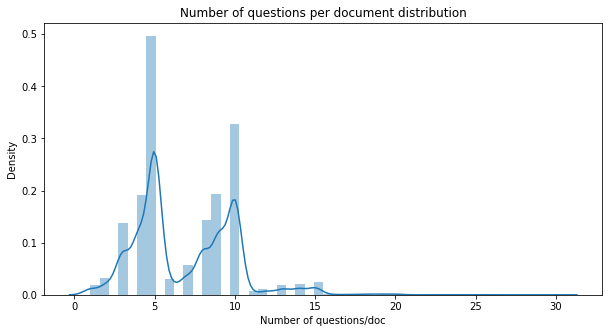

In [30]:
# Visualizing the distribution of number of questions per/document for the whole dataset

df_by_context = df['context'].value_counts().rename_axis('unique_values').reset_index(name='counts')
plt.figure(figsize = (10,5))
plt.title('Number of questions per document distribution')
sns.distplot(df_by_context['counts'])
plt.xlabel('Number of questions/doc') 
plt.ylabel('Density')
plt.show()

There are mostly **5 or 10 questions** asked per document in the dataset.

In [6]:
avg_context_length = df['context_length'].mean()
print("Average context length is {}".format(avg_context_length))

Average context length is 754.5662873410631


/Users/ankushraut/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


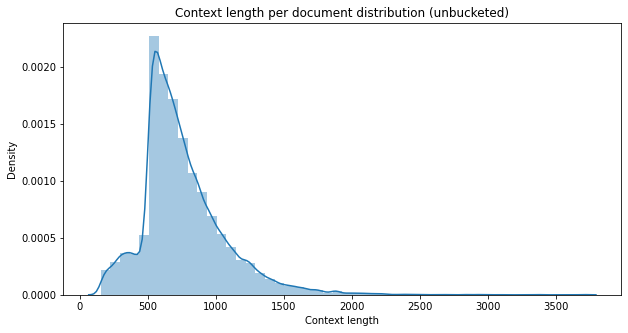

In [7]:
# Visualizing the distribution of context length for the whole dataset

plt.figure(figsize = (10,5))
plt.title('Context length per document distribution (unbucketed)')
ax = sns.distplot(df['context_length'])
ax.set(xlabel='Context length', ylabel='Density')
plt.show()

We can see a huge spike in the graph above around context length of 700 which is also justified by the 
the mean context length calculated above for the dataset.

/Users/ankushraut/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


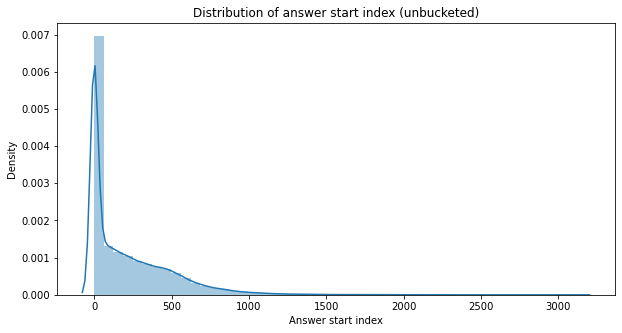

In [8]:
# Visualizing the distribution of answer start index for the entire dataset

df['answer_text'] = df['answers'].apply(lambda x: x['text'][0] if len(x['text'])>0 else '')
df['start_index']= df['answers'].apply(lambda x: x['answer_start'][0] if len(x['answer_start'])>0 else -1)

plt.figure(figsize = (10,5))
plt.title('Distribution of answer start index (unbucketed)')
ax = sns.distplot(df['start_index'])
ax.set(xlabel='Answer start index', ylabel='Density')
plt.show()

/Users/ankushraut/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


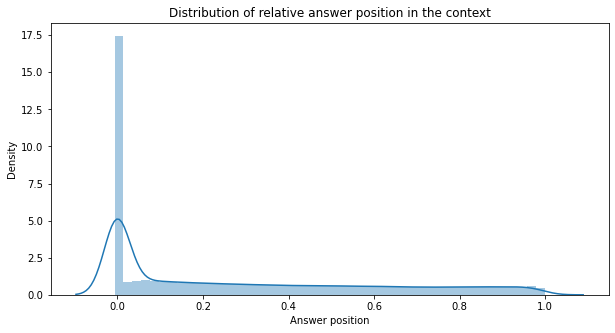

In [9]:
# Here we define a new metric answer_position = start_index/context_length that provides
# information about the relative position of answer in the context/paragraph

df['answer_pos'] = df['start_index']/df['context_length']
plt.figure(figsize = (10,5))
plt.title('Distribution of relative answer position in the context')
ax = sns.distplot(df['answer_pos'])
ax.set(xlabel='Answer position', ylabel='Density')
plt.show()

We can see that the dataset is already stratified on the relative answer position, with a spike at 0 due to unanswerable questions. It's perfect for evaluating the trend of accuracy with the relative position of the answer.

## Sampling Strategy

We create 3 samples, all stratified on different characteristics. The reason for that is we have computational limitations preventing us from obtaining predictions on the entire dataset in a small span of time. Here are the criteria for stratifying the sample.

1. Equal distribution of answer start index buckets.
2. Equal distribution of the buckets of relative answer position.
3. Equal distribution of context length buckets.

We chose a 1% sample for each of the criteria mentioned above. We'll further our research by predicting on an even larger sample.

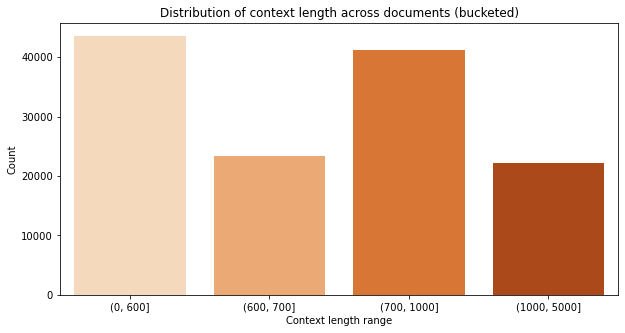

In [10]:
bins = [0,600,700,1000,5000]
df['context_cat'] = pd.cut(df['context_length'], bins=bins)
df_context_cat_valc = df['context_cat'].value_counts().rename_axis('unique_values').reset_index(name='counts')


plt.figure(figsize = (10,5))
plt.title("Distribution of context length across documents (bucketed)")
ax = sns.barplot(x = 'unique_values',
            y = 'counts',
            data = df_context_cat_valc,
            palette = "Oranges")

ax.set(xlabel='Context length range', ylabel='Count')
plt.show()
# Show the plot
plt.show()

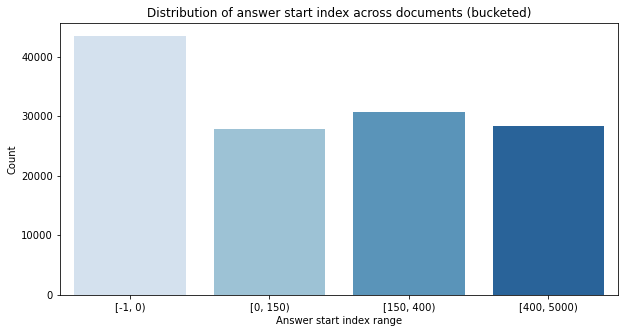

In [11]:
# Barplot showing the number of documents for each of the answer start index range. 

bins = [-1,0,150,400,5000]
df['answer_start_cat']= pd.cut(df['start_index'], bins=bins,include_lowest=True,right=False)
df_answer_start_cat = df['answer_start_cat'].value_counts().rename_axis('unique_values').reset_index(name='counts')

plt.figure(figsize = (10,5))
plt.title('Distribution of answer start index across documents (bucketed)')
ax = sns.barplot(x = 'unique_values',
            y = 'counts',
            data = df_answer_start_cat,
            palette = "Blues")

ax.set(xlabel='Answer start index range', ylabel='Count')
plt.show()
# Show the plot
plt.show()

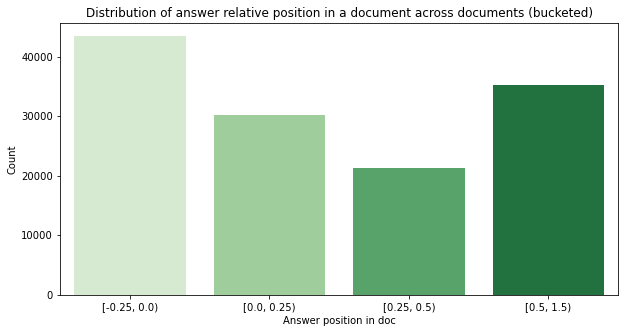

In [12]:
bins = [-0.25,0,0.25,0.5,1.5]
df['answer_pos_cat']= pd.cut(df['answer_pos'], bins=bins,include_lowest=True,right=False)
df_answer_pos_cat = df['answer_pos_cat'].value_counts().rename_axis('unique_values').reset_index(name='counts')

plt.figure(figsize = (10,5))
plt.title('Distribution of answer relative position in a document across documents (bucketed)')
ax = sns.barplot(x = 'unique_values',
            y = 'counts',
            data = df_answer_pos_cat,
            palette = "Greens")

ax.set(xlabel='Answer position in doc', ylabel='Count')
plt.show()
# Show the plot
plt.show()

## Stratified Sampling 

After categorizing the target variables (context length, answer start index and relative answer position in the document) we perform stratified sampling and produce the three samples stratified on different metrics.

This has already been done and the stored files are imported below the stratified sampling code.

In [13]:
# df.head()

# for col in ['context_cat', 'answer_start_cat', 'answer_pos_cat']:
#     df[col] = df[col].astype(str)

In [14]:
# train_context_length, test_context_length = train_test_split(df,
#                                                     stratify=df.context_cat, 
#                                                     test_size=0.01,random_state=42)

# test_context_length.to_csv('df_context.csv', index = False)

In [15]:
# train_answer_pos, test_answer_pos = train_test_split(df,
#                                                     stratify=df.answer_pos_cat, 
#                                                     test_size=0.01,random_state=42)

# test_answer_pos.to_csv('answer_pos.csv', index = False)

In [16]:
# train_answer_start, test_answer_start = train_test_split(df,
#                                                     stratify=df.answer_start_cat, 
#                                                     test_size=0.01,random_state=42)

# test_answer_start.to_csv('answer_start.csv', index = False)

In [17]:
dataset1 = pd.read_csv('answer_start.csv') 
dataset2 = pd.read_csv('answer_pos.csv')
dataset3 = pd.read_csv('df_context.csv')

# Model pipeline

This section includes the build of the open-source masked language modeling-based models for question answering. We have used **Longformer (max context length 4096)** and **BERT (max context length 512)**. 

The reason for this choice of models was to have one large-context and one small-context models and compare their performance on a question answering task. 

Not only do we require the accuracies but we also want to understand if the contextual retrievability of either of these models is consistent across different regions in the document.

**Modular code for obtaining predictions** - We build a class that takes the dataset as input, the number of questions that need to be processed, the max context length that needs to be considered, and the model that you are using. Then we initialize this class and run the functions within to obtain predictions.

The prediction pipeline is also built using the **Hugging Face** library. It provides an easy way to import language model heads and tokenizers that can be used to build a model for any use case.

In [18]:
class QAmodel:
    def __init__(self, dataset, model, num_questions, max_length):
        
        # Initialize some variables
        
        self.dataset = dataset
        self.model = model
        self.num_questions = num_questions
        self.max_length = max_length
        self.model_answers_df = None
        
    
    # Function for returning answers to an input set of question and context

    def long_context_qa(self, question, context):
        
        # We need a different Tokenizer and different QuestionAnswering head for the longformer model
        # For most other models the AutoTokenizer class and the AutoModel class should work
        # If GPU is available, then we load the model to a GPU using cuda
        
        if self.model == "allenai/longformer-large-4096-finetuned-triviaqa":
            tokenizer = transformers.LongformerTokenizer.from_pretrained(self.model)
            model_call = transformers.LongformerForQuestionAnswering.from_pretrained(self.model)
            model_call.to("cuda")
        else:
            tokenizer = transformers.AutoTokenizer.from_pretrained(self.model)
            model_call = transformers.AutoModelForQuestionAnswering.from_pretrained(self.model)
            model_call.to('cuda')
        
        # Here we tokenize the inputs, depending on the model, different tokenizer with different max_context_length will be called
        
        inputs = tokenizer(question, context, padding="max_length",truncation=True,
                       return_tensors="pt",max_length = self.max_length)
        
        # If GPU is available we load the inputs to GPU using CUDA
        
        inputs.to("cuda")
        
        # We'll call the model without calling gradients
        
        with torch.no_grad():
            output = model_call(**inputs)
        
        # The model gives multiple outputs, it'll give logits corresponding all possible start and end indices
        # We'll pick the indices with highest logits 
        
        answer_start = torch.argmax(output['start_logits']).item()
        answer_end = torch.argmax(output['end_logits']).item()
        
        # We'll select the answer from the inputs based on the selected answer start and end logits 
        
        input_ids = inputs["input_ids"][0].cpu().numpy()
        answer_tokens = input_ids[answer_start:answer_end + 1]
        
        # The tokenizer will decode the answer from the selected tokens 
        answer = tokenizer.decode(answer_tokens)
        
        return answer

    # This function will give you if there's a match
    # We're not using exact match, rather we're checking if the actual answer is present in the predicted answer
    # This is being done only for answerable questions for now
    
    @staticmethod
    def answer_matcher(actual, predicted):
        try:
            return 1 if actual in predicted else 0
        except:
            return np.nan
        
    
    # Here we'll sequentially call the question answering function for all question, context pairs in the dataset
    
    def process_questions(self):
        model_answers = []
        
        for i in tqdm(range(self.num_questions)):
            answer = self.long_context_qa(self.dataset['question'][i], self.dataset['context'][i])
            model_answers.append(answer)

        self.model_answers_df = pd.DataFrame({
            'actual_answer': self.dataset['answer_text'][:self.num_questions],
            'predicted_answer': model_answers
        })
        
        # Lowercase actual and predicted answers and call answer matcher to obtain match 
        
        self.model_answers_df.actual_answer = self.model_answers_df.actual_answer.str.strip().str.lower()
        self.model_answers_df.predicted_answer = self.model_answers_df.predicted_answer.str.strip().str.lower()
        self.model_answers_df['answer_match'] = self.model_answers_df.apply(
            lambda x: self.answer_matcher(x['actual_answer'], x['predicted_answer']), axis=1)

        return self.model_answers_df
    
    # This function outputs the accuracy based on the answer_match function
    
    def get_accuracy(self):
        accuracy = sum(self.model_answers_df['answer_match']) * 100 / self.num_questions
        return accuracy

In [19]:
# Defining a list of models to be tested and their context lengths 

models = ["bert-base-uncased", "allenai/longformer-large-4096-finetuned-triviaqa"]
context_lengths = [512, 4096]

It takes quite some time to run the code below, it was run on Colab and the files were saved, this should be run on systems with high RAM and preferably with GPU.

In [20]:
# # Iterate over all datasets and models

# i = 0
# for dataset in [dataset1, dataset2, dataset3]:
#     temp_dataset = dataset.copy()
#     for model,context_length in zip(models, context_lengths):
        
#         # Call the QAmodel class
#         d_qamodel = QAmodel(temp_dataset, model, len(temp_dataset), context_length)
        
#         # Obtain answers using the process_questions function
#         answers = d_qamodel.process_questions()
        
#         # Define a nomenclature for the files to be stored, this can be altered later 
#         key = model[8:]+'_'+str(i)
#         answers.to_csv(key+'.csv')
    
#     i+=1

# Results

We evaluate the results in this section. We check how the accuracy changes with the answer start index, this trend can be observed for other stratified samples too.

The observations below are for one BERT output and 1 Longformer output. We have used the BERT output on the sample stratified on the answer start index, while for Longformer we have used the output on the sample stratified on the context length.

In [22]:
# function for postprocessing the predictions and retrieving the results along with original files

def prepare_results(df_train, df_predict,by):
    
    # Convert the answers to lowercase
    df_train['answer_text'] = df_train['answer_text'].astype(str).apply(lambda x: x.lower())
    
    # Join the answers table to the original table
    df_merged = pd.concat([df_train, df_predict],axis=1)
    
    # Replace NaNs with empty strings
    df_merged['actual_answer'].fillna('',inplace=True)
    df_merged['predicted_answer'].fillna('',inplace=True)
    df_merged['answer_match'].fillna(0,inplace=True)
    
    # To obtain accuracy for unanswerable cases, if the model outputs nothing to unanswerable questions, we consider that an answer match
    df_merged['both_empty'] = np.where((df_merged['actual_answer'] == '') & (df_merged['predicted_answer'] == ''),1, 0)
    df_merged['answer_match'] = df_merged['answer_match'] + df_merged['both_empty']
    df_stats = df_merged[[by,'answer_match']].groupby(by).mean()*100
    df_stats = df_stats.reset_index()
    return df_stats

### BERT

In [24]:
df_answer_start_train = pd.read_csv("answer_start.csv")
df_bb_astart = pd.read_csv("bert-base-uncased_2_1.csv")

/var/folders/_x/8vptzk216z9d2gt2lh5spy9m0000gn/T/ipykernel_13164/450668427.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['actual_answer'].fillna('',inplace=True)
/var/folders/_x/8vptzk216z9d2gt2lh5spy9m0000gn/T/ipykernel_13164/450668427.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['predicted_answer'].fillna('',inplace=True)
/var/folders/_x/8vptzk216z9d2gt2lh5spy9m0000gn/T/ipykernel_13164/450668427.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

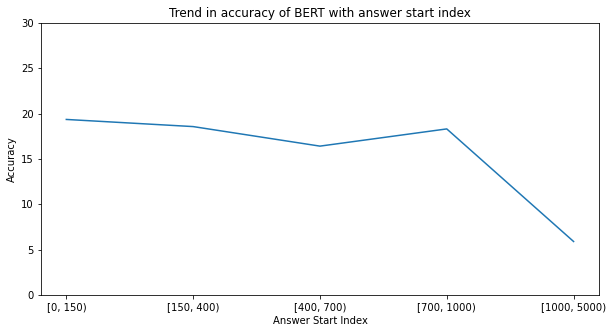

In [25]:
bins = [-1,0,150,400,700,1000,5000]
df_answer_start_train['answer_start_cat']= pd.cut(df_answer_start_train['start_index'], bins=bins,include_lowest=True,right=False)

df_stats_bb_astart_df =  prepare_results(df_answer_start_train, df_bb_astart,by='answer_start_cat' )

df_stats_bb_astart_df['answer_start_cat'] = df_stats_bb_astart_df['answer_start_cat'].astype('str')

plt.figure(figsize = (10,5))
plt.title('Trend in accuracy of BERT with answer start index')
ax = sns.lineplot(x = 'answer_start_cat',
            y = 'answer_match',
            data = df_stats_bb_astart_df,
            palette = "Greens")

ax.set(xlabel='Answer Start Index', ylabel='Accuracy')
plt.ylim(0, 30)

plt.show()

### LongFormer

In [27]:
df_context_train = pd.read_csv("df_context.csv")
df_lf_context = pd.read_csv("longformer-large-4096-finetuned-triviaqa_3.csv")

/var/folders/_x/8vptzk216z9d2gt2lh5spy9m0000gn/T/ipykernel_13164/450668427.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['actual_answer'].fillna('',inplace=True)
/var/folders/_x/8vptzk216z9d2gt2lh5spy9m0000gn/T/ipykernel_13164/450668427.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['predicted_answer'].fillna('',inplace=True)
/var/folders/_x/8vptzk216z9d2gt2lh5spy9m0000gn/T/ipykernel_13164/450668427.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

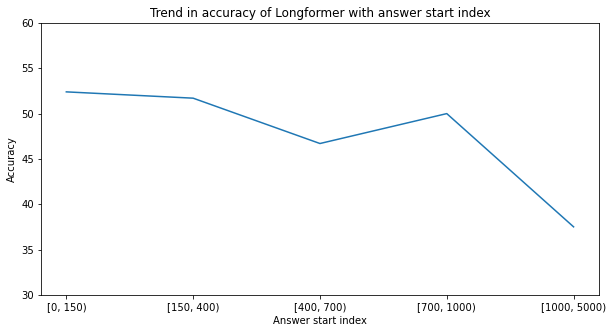

In [28]:
bins = [-1,0,150,400,700,1000,5000]
df_context_train['answer_start_cat']= pd.cut(df_context_train['start_index'], bins=bins,include_lowest=True,right=False)
df_stats_lf_astart_df =  prepare_results(df_context_train, df_lf_context,'answer_start_cat' )
df_stats_lf_astart_df['answer_start_cat'] = df_stats_lf_astart_df['answer_start_cat'].astype('str')

plt.figure(figsize = (10,5))
plt.title('Trend in accuracy of Longformer with answer start index')
ax = sns.lineplot(x = 'answer_start_cat',
            y = 'answer_match',
            data = df_stats_lf_astart_df)

ax.set(xlabel='Answer start index', ylabel='Accuracy')
plt.ylim(30, 60)

# Show the plot
plt.show()

## Inference

It can be inferred that while Longformer in general has a much better accuracy than BERT, both these models perform poorly when the answer is located towards the end of the context.

**Next steps**:

1. This is merely an observation on a small sample. To confirm the actual trend, we need to obtain results on the entire dataset without any sampling.

2. We also need to vary the language model heads used. How does the accuracy change if we use the CausalLM head (causal language modeling) instead of the question answering head, and pass prompts instead of question-context pairs?

3. We need to try bigger datasets and bigger language models.

These steps will help arrive at a more reliable observation about the contextual retrievability of large language models. But we do have a certain degree of confidence based on the initial observations that language models lack the ability of inferring from contexts irrespective of the location of the information.

## References

1. Lost in the Middle: How Language Models Use Long Contexts (https://www-cs.stanford.edu/~nfliu/papers/lost-in-the-middle.arxiv2023.pdf)

2. Know What You Don't Know: Unanswerable Questions for SQuAD (https://arxiv.org/abs/1806.03822)

3. HOTPOTQA: A Dataset for Diverse, Explainable Multi-hop Question Answering (https://nlp.stanford.edu/pubs/yang2018hotpotqa.pdf)